In [153]:
import sys, os, time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

1.4.0


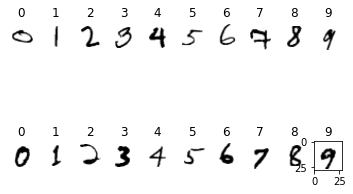

In [154]:
train_mnist=datasets.MNIST('data', train=True, download=True)
y_train_orig=train_mnist.targets.numpy()
for i in range(10):
  num_digits=2
  indices=np.random.choice(np.where(y_train_orig==i)[0],num_digits)
  for j in range(num_digits):
    plt.axis('off')
    plt.subplot(num_digits,10,10*j+i+1).set_title('{}'.format(i))
    img,_=train_mnist[indices[j]]
    plt.imshow(img, cmap='Greys')
plt.show()

In [155]:
batch_size = 128
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(1)

normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

train_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
train_dataset = datasets.MNIST(root='data', train=True, 
                download=True, transform=train_transform)


test_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
test_dataset = datasets.MNIST(root='data', train=False, 
            download=True, transform=test_transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
num_train = len(train_dataset)
split = int(np.floor(0.1 * num_train))
train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, **kwargs)

True
54000 6000


In [0]:
input_size=train_dataset[0][0].shape
num_classes=len(train_dataset.classes)

class Net(nn.Module):
    def __init__(self,
                 n_hidden,
                 dropout):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(np.prod(input_size), n_hidden)
        self.fc1 = nn.Linear(n_hidden, n_hidden*2)
        self.fc2 = nn.Linear(n_hidden*2, n_hidden)
        self.out = nn.Linear(n_hidden, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc0(x)
        x = self.dropout(x)
        x_relu1 = self.fc1(x).clamp(min=0)  # basically relu
        x = self.dropout(x_relu1)
        x_relu2 = self.fc2(x_relu1).clamp(min=0)  # basically relu
        x = self.dropout(x_relu2)
        x = self.out(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
def train(model, device, train_loader, optimizer, epoch):
  train_loss = 0.0
  total_train = 0
  correct_train = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % 10 == 0:
        display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)
      
      # accuracy
      _, predicted = torch.max(output.data, 1)
      train_loss += loss.item()
      total_train += target.nelement()  # number of pixel in the batch
      correct_train += predicted.eq(target.data).sum().item() # sum all precited pixel values
  
  epoch_loss = train_loss / len(train_loader.dataset)
  epoch_acc = 100.*(correct_train / total_train)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
      epoch_loss,correct_train, total_train, epoch_acc))
  return epoch_loss,epoch_acc

In [0]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy=100. * correct / len(test_loader.dataset)

  print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))
  return test_loss,accuracy

In [160]:
epochs = 20
device = torch.device("cuda" if use_cuda else "cpu")

start_time = time.time()

model = Net(1200, 0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
train_losses,val_losses=[],[]
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    scheduler.step()
    epoch_time = round(time.time() - epoch_start, 2)
    print(f'Epoch Train Time: {int(epoch_time // 60)}m {epoch_time % 60}s\n')

elapsed = time.time() - start_time
print(f'Training complete in {int(elapsed // 60)}m {elapsed // 60}s')

'Train Epoch: 1 [6400/54000 (12%)] Loss: 0.372236'

KeyboardInterrupt: ignored

In [0]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
print(len(train_losses),len(val_losses))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### SGD tests (lr 0.1)
- From the start: dropout (0.3); increased number of hidden layers (1) and nodes (1000): **94%**;
- 2 hidden (784, 1000, 2000, 1000, out); Relu at fc1 and fc2: **98.06%**;
- Dropout 0.4 and 0.35 peaked ~ 97.73%. It appears that 0.3 is the best, but we'll try less instead.
- 1200-2400: **98.17%**;
- Decreasing dropout to 0.2 yielded worse results on both dev and test sets. Seems like 0.3 is the best.
- Increasing number of neurons until it caps the accuracy by this means (should not exactly overfit since we have regularization)
- Both dev and test accuracy decreased at 1400. Seems like 1200 is the best choice for 2-layer configuration.
- 0.1 -> 0.05 lr. Appears stuck on a suboptimal solution *(97.5%)*.
- 0.7 -> 0.5 scheduler gamma - worse;
- Not dropping out fc0: *98.13%*.
- Avg time: 4m 04s per 20 epochs.

### Adam (lr 0.001):
- **98.49%**. It appears that change in optimizer did not affect training time (4:04 as before)
- Dev loss fluctuates wildly; let's try larger dropout, 0.4.
- Larger dropout did not affect accuracy at all. However, dev loss optima (according to graph) was at ~18 epochs. Let's train less.
- It was a correct decision: 18 epochs yielded **98.62%**.
- 1400 nodes, old (0.3) dropout: *98.59*.
- Best parameters so far: 1200 + 0.4 at 18 epochs. Let's play with regularization.
- Introduced **weight decay (l2 regularization)** to Adam while keeping dropout.
- 0.1: immediate sharp decrease, did not go past first two epochs;
- 0.01: seems stuck at a suboptimal solution.
- 0.001: 98.26%.
- 0.001 + 0.3 d/o: 98.31%, although l2 in combination with d/o doesn't seem to be working out as well. Let's turn off dropout.
- L2 alone yields worse results than initial net. It seems d/o is better suited for the task.